In [1]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt
from typing import Callable, List, Dict, Tuple, Any, Union
import gc

gc.collect()

def time_operation(operation: Callable, *args, repeat: int = 3) -> List[float]:
    """Time a GPU operation with proper synchronization.
    
    Args:
        operation: Function to time
        args: Arguments to pass to the operation
        repeat: Number of times to repeat timing
        
    Returns:
        List of elapsed times in seconds
    """
    times = []
    for _ in range(repeat):
        cp.cuda.runtime.deviceSynchronize()
        start = time.perf_counter()
        result = operation(*args)
        cp.cuda.Stream.null.synchronize()
        elapsed = time.perf_counter() - start
        times.append(elapsed)
    
    return result, times

def calculate_metrics(tensor_result, reference_result, tensor_times, reference_times, flops):
    """Calculate performance and accuracy metrics.
    
    Args:
        tensor_result: Result from tensor core implementation
        reference_result: Result from reference implementation
        tensor_times: List of timing results for tensor implementation
        reference_times: List of timing results for reference implementation
        flops: Number of floating-point operations
        
    Returns:
        Dictionary of metrics
    """
    # Performance metrics
    tensor_min_time = min(tensor_times)
    reference_min_time = min(reference_times)
    
    tensor_gflops = flops / (tensor_min_time * 1e9)
    reference_gflops = flops / (reference_min_time * 1e9)
    speedup = reference_min_time / tensor_min_time
    
    # Accuracy metrics
    max_diff = float(cp.max(cp.abs(tensor_result - reference_result)))
    mean_diff = float(cp.mean(cp.abs(tensor_result - reference_result)))
    
    # Sample outputs for verification
    if isinstance(tensor_result, cp.ndarray):
        tensor_sample = cp.asnumpy(tensor_result.reshape(-1)[:5])
        reference_sample = cp.asnumpy(reference_result.reshape(-1)[:5])
    else:
        tensor_sample = tensor_result[:5] if hasattr(tensor_result, '__getitem__') else tensor_result
        reference_sample = reference_result[:5] if hasattr(reference_result, '__getitem__') else reference_result
    
    return {
        'tensor_times': tensor_times,
        'reference_times': reference_times,
        'tensor_gflops': tensor_gflops,
        'reference_gflops': reference_gflops,
        'speedup': speedup,
        'max_diff': max_diff,
        'mean_diff': mean_diff,
        'tensor_sample': tensor_sample,
        'reference_sample': reference_sample
    }

def print_results(results: List[Dict[str, Any]], operation_name: str):
    """Print formatted benchmark results.
    
    Args:
        results: List of result dictionaries
        operation_name: Name of the operation being benchmarked
    """
    print(f"\n{'=' * 80}")
    print(f"Results for {operation_name}")
    print(f"{'=' * 80}")
    
    # Print performance comparison
    print(f"\nPerformance Comparison:")
    print(f"{'-' * 80}")
    print(f"{'Shape':25} {'Tensor GFLOPS':>15} {'Reference GFLOPS':>15} {'Speedup':>12} {'Max Diff':>12} {'Mean Diff':>12}")
    print(f"{'-' * 80}")
    
    for r in results:
        shape_str = str(r['shape'])
        print(f"{shape_str:25} {r['tensor_gflops']:15.2f} {r['reference_gflops']:15.2f} "
              f"{r['speedup']:12.2f} {r['max_diff']:12.2e} {r['mean_diff']:12.2e}")
    
    # Print sample values
    print(f"\nSample Output Comparison (first 5 values):")
    print(f"{'-' * 80}")
    for r in results:
        print(f"\nShape: {r['shape']}")
        print(f"Tensor: {r['tensor_sample']}")
        print(f"Reference: {r['reference_sample']}")

def plot_benchmark_results(results: List[Dict[str, Any]], operation_name: str):
    """Create standard plots for benchmark results.
    
    Args:
        results: List of result dictionaries
        operation_name: Name of the operation being benchmarked
    """
    # Create standard plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Prepare data
    x = np.arange(len(results))
    width = 0.35
    
    tensor_gflops = [r['tensor_gflops'] for r in results]
    reference_gflops = [r['reference_gflops'] for r in results]
    
    # Performance comparison
    ax1.bar(x - width/2, tensor_gflops, width, label='Tensor Cores')
    ax1.bar(x + width/2, reference_gflops, width, label='Reference')
    ax1.set_ylabel('GFLOPS')
    ax1.set_title(f'{operation_name}\nPerformance Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels([str(r['shape']) for r in results], rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy comparison
    max_diffs = [r['max_diff'] for r in results]
    mean_diffs = [r['mean_diff'] for r in results]
    
    ax2.plot(x, max_diffs, 'o-', label='Max Difference')
    ax2.plot(x, mean_diffs, 's-', label='Mean Difference')
    ax2.set_ylabel('Absolute Difference')
    ax2.set_title(f'{operation_name}\nAccuracy Comparison')
    ax2.set_xticks(x)
    ax2.set_xticklabels([str(r['shape']) for r in results], rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

def run_benchmark(
    operation_name: str, 
    tensor_op: Callable, 
    reference_op: Callable, 
    shapes: List, 
    create_inputs: Callable,
    calculate_flops: Callable
) -> List[Dict[str, Any]]:
    """Run a complete benchmark comparing tensor and reference implementations.
    
    Args:
        operation_name: Name of the operation
        tensor_op: Tensor core implementation function
        reference_op: Reference implementation function
        shapes: List of shapes to test
        create_inputs: Function that creates input data for each shape
        calculate_flops: Function that calculates FLOPS for the operation
        
    Returns:
        List of benchmark results
    """
    print(f"\nBenchmarking {operation_name}...")
    results = []
    
    for shape in shapes:
        print(f"\nShape: {shape}")
        try:
            # Create inputs for this shape
            inputs = create_inputs(shape)
            
            # Calculate FLOPS for this shape
            flops = calculate_flops(shape)
            
            # Time tensor implementation
            tensor_result, tensor_times = time_operation(tensor_op, *inputs)
            
            # Time reference implementation
            reference_result, reference_times = time_operation(reference_op, *inputs)
            
            # Calculate and store metrics
            metrics = calculate_metrics(
                tensor_result, reference_result, 
                tensor_times, reference_times, 
                flops
            )
            
            # Add shape and FLOPS to results
            metrics['shape'] = shape
            metrics['flops'] = flops
            results.append(metrics)
            
            # Cleanup
            for inp in inputs:
                if isinstance(inp, cp.ndarray):
                    del inp
            if isinstance(tensor_result, cp.ndarray):
                del tensor_result
            if isinstance(reference_result, cp.ndarray):
                del reference_result
                
            cp.cuda.runtime.deviceSynchronize()
            cp.get_default_memory_pool().free_all_blocks()
            
        except Exception as e:
            print(f"Error testing shape {shape}: {e}")
            import traceback
            traceback.print_exc()
    
    # Print and plot results
    if results:
        print_results(results, operation_name)
        plot_benchmark_results(results, operation_name)
    
    return results

def cleanup():
    """Free all GPU memory."""
    cp.cuda.runtime.deviceSynchronize()
    cp.get_default_memory_pool().free_all_blocks()
    cp.get_default_pinned_memory_pool().free_all_blocks()

    gc.collect()



Initializing CUDA...
CUDA initialization complete
Loading library: ./cuda_matlib.so
Function signatures configured
Initializing CUDA resources (one-time operation)...
CUDA resources initialized

Benchmarking Matrix Power...

Shape: (16, 16)

Shape: (32, 32)

Shape: (64, 64)

Shape: (128, 128)

Shape: (256, 256)

Shape: (512, 512)

Shape: (768, 768)

Shape: (1024, 1024)

Shape: (2048, 2048)

Shape: (4048, 4048)

Shape: (8192, 8192)
Error testing shape (8192, 8192): Out of memory allocating 536,870,912 bytes (allocated so far: 2,147,483,648 bytes).

Results for Matrix Power

Performance Comparison:
--------------------------------------------------------------------------------
Shape                       Tensor GFLOPS Reference GFLOPS      Speedup     Max Diff    Mean Diff
--------------------------------------------------------------------------------
(16, 16)                             0.55            0.20         2.73     1.07e-07     2.46e-08
(32, 32)                             3.

Traceback (most recent call last):
  File "/tmp/ipykernel_87232/2609331069.py", line 188, in run_benchmark
    reference_result, reference_times = time_operation(reference_op, *inputs)
                                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_87232/2609331069.py", line 25, in time_operation
    result = operation(*args)
             ^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_87232/3576072830.py", line 54, in reference_op
    return cp.linalg.matrix_power(a, p)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/home/fraser/anaconda3/envs/py312/lib/python3.12/site-packages/cupy/linalg/_product.py", line 375, in matrix_power
    Z = M if Z is None else cupy.matmul(Z, Z)
                            ^^^^^^^^^^^^^^^^^
  File "/var/home/fraser/anaconda3/envs/py312/lib/python3.12/site-packages/cupy/_core/_gufuncs.py", line 669, in __call__
    outs = cupy.empty(out_shape, dtype=ret_dtype, order=filter_order)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

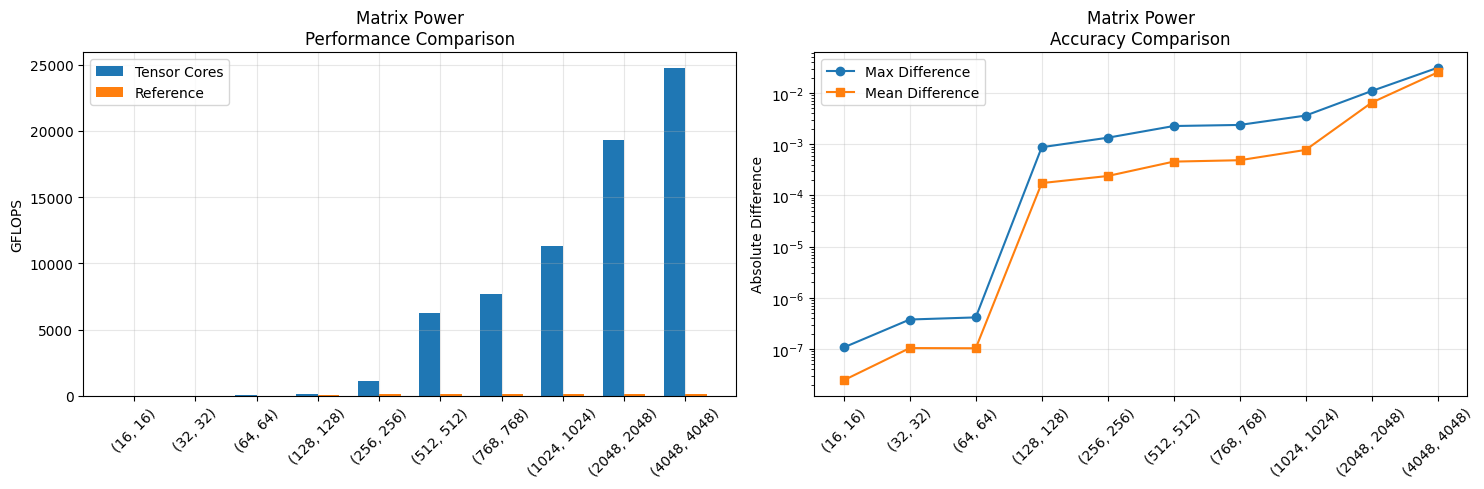

In [2]:
import numpy as np
import cupy as cp
from tensor_matrix_ops import TensorMatrixOps
# from benchmark_utils import run_benchmark

def test_matrix_power():
    """Benchmark matrix power operations."""
    # Initialize TensorMatrixOps
    tensor_ops = TensorMatrixOps()
    
    # Operation name
    operation_name = "Matrix Power"
    
    # Power to use for testing
    power = 4
    
    # Shapes to test (n×n matrices)
    shapes = [
        (16, 16),
        (32, 32),
        (64, 64),
        (128, 128),
        (256, 256),
        (512, 512),
        (768, 768),
        (1024, 1024),
        (2048, 2048),
        (4048, 4048),
        (8192, 8192)
    ]
    
    # Create input data function
    def create_inputs(shape):
        """Create a random matrix in Fortran order for matrix power."""
        a = cp.asfortranarray(cp.random.random(shape, dtype=cp.float64))
        # Scale to prevent numerical overflow
        a /= (cp.sqrt(shape[0]) * 1.1)
        return [a, power]  # Return as list for unpacking
    
    # Calculate FLOPS
    def calculate_flops(shape):
        """Calculate FLOPS for matrix power operation."""
        n = shape[0]
        # Matrix power A^p requires p-1 matrix multiplications
        # Each matrix multiplication is 2*n^3 FLOPS
        return 2 * n * n * n * (power - 1)
    
    # Define tensor operation
    def tensor_op(a, p):
        return tensor_ops.matrix_power(a, p)
    
    # Define reference operation
    def reference_op(a, p):
        return cp.linalg.matrix_power(a, p)
    
    # Run the benchmark
    results = run_benchmark(
        operation_name,
        tensor_op,
        reference_op,
        shapes,
        create_inputs,
        calculate_flops
    )
    
    return results

if __name__ == "__main__":
    test_matrix_power()
    cleanup()

Initializing CUDA...
CUDA initialization complete
Function signatures configured

Benchmarking Matrix Multiplication...

Shape: (16, 16, 16)

Shape: (32, 32, 32)

Shape: (64, 64, 64)

Shape: (128, 128, 128)

Shape: (256, 256, 256)

Shape: (512, 512, 512)

Shape: (640, 640, 640)

Shape: (1024, 1024, 1024)

Shape: (2048, 2048, 2048)

Shape: (4048, 4048, 4048)

Shape: (7192, 7192, 7192)
Error testing shape (7192, 7192, 7192): Out of memory allocating 413,798,912 bytes (allocated so far: 2,192,066,560 bytes).

Results for Matrix Multiplication

Performance Comparison:
--------------------------------------------------------------------------------
Shape                       Tensor GFLOPS Reference GFLOPS      Speedup     Max Diff    Mean Diff
--------------------------------------------------------------------------------
(16, 16, 16)                         0.30            0.13         2.32     2.64e-08     6.70e-09
(32, 32, 32)                         2.50            1.04         2.40  

Traceback (most recent call last):
  File "/tmp/ipykernel_87232/2609331069.py", line 191, in run_benchmark
    metrics = calculate_metrics(
              ^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_87232/2609331069.py", line 54, in calculate_metrics
    max_diff = float(cp.max(cp.abs(tensor_result - reference_result)))
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "cupy/_core/_kernel.pyx", line 1350, in cupy._core._kernel.ufunc.__call__
  File "cupy/_core/_kernel.pyx", line 645, in cupy._core._kernel._get_out_args_from_optionals
  File "cupy/_core/core.pyx", line 2836, in cupy._core.core._ndarray_init
  File "cupy/_core/core.pyx", line 243, in cupy._core.core._ndarray_base._init_fast
  File "cupy/cuda/memory.pyx", line 738, in cupy.cuda.memory.alloc
  File "cupy/cuda/memory.pyx", line 1424, in cupy.cuda.memory.MemoryPool.malloc
  File "cupy/cuda/memory.pyx", line 1445, in cupy.cuda.memory.MemoryPool.malloc
  File "cupy/cuda/memory.pyx", line 1116, in cupy.cu

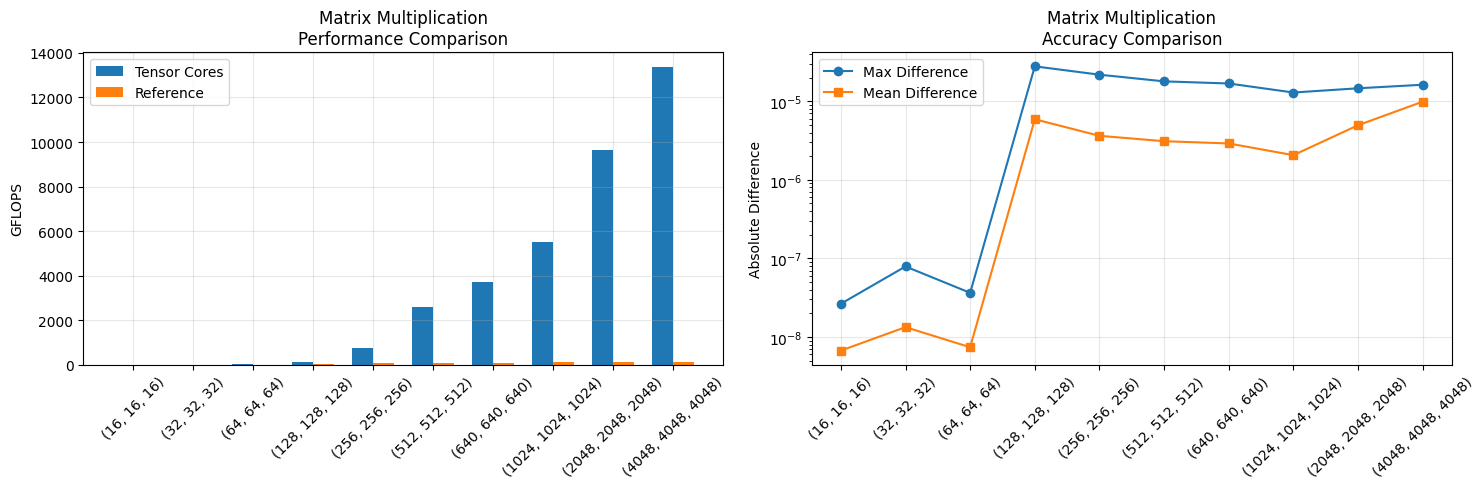

In [3]:
import numpy as np
import cupy as cp
from tensor_matrix_ops import TensorMatrixOps
# from benchmark_utils import run_benchmark

def test_matrix_multiply():
    """Benchmark matrix multiplication operations."""
    # Initialize TensorMatrixOps
    tensor_ops = TensorMatrixOps()
    
    # Operation name
    operation_name = "Matrix Multiplication"
    
    # Shapes to test
    shapes = [
        (16, 16, 16),   # (M, K, N)
        (32, 32, 32),
        (64, 64, 64),
        (128, 128, 128),
        (256, 256, 256),
        (512, 512, 512),
        (640, 640, 640),
        (1024, 1024, 1024),
        (2048, 2048, 2048),
        (4048, 4048, 4048),
        (7192, 7192, 7192)
    ]
    
    # Create input data function
    def create_inputs(shape):
        """Create random matrices in Fortran order for matrix multiplication."""
        m, k, n = shape
        a = cp.asfortranarray(cp.random.random((m, k), dtype=cp.float64))
        b = cp.asfortranarray(cp.random.random((k, n), dtype=cp.float64))
        
        # Scale to prevent numerical overflow
        a /= (cp.sqrt(k) * 1.1)
        b /= (cp.sqrt(k) * 1.1)
        
        return [a, b]
    
    # Calculate FLOPS
    def calculate_flops(shape):
        """Calculate FLOPS for matrix multiplication."""
        m, k, n = shape
        # Matrix multiplication requires 2*M*N*K FLOPS
        return 2 * m * n * k
    
    # Define tensor operation
    def tensor_op(a, b):
        return tensor_ops.matmul(a, b)
    
    # Define reference operation
    def reference_op(a, b):
        return cp.matmul(a, b)
    
    # Run the benchmark
    results = run_benchmark(
        operation_name,
        tensor_op,
        reference_op,
        shapes,
        create_inputs,
        calculate_flops
    )
    
    return results

if __name__ == "__main__":
    test_matrix_multiply()
    cleanup()

Initializing CUDA...
CUDA initialization complete
Function signatures configured

Benchmarking Batched Matrix Multiplication...

Shape: (8, 16, 16, 16)

Shape: (8, 32, 32, 32)

Shape: (8, 64, 64, 64)

Shape: (8, 128, 128, 128)

Shape: (8, 256, 256, 256)

Shape: (8, 1024, 1024, 1024)

Shape: (8, 2048, 2048, 2048)

Results for Batched Matrix Multiplication

Performance Comparison:
--------------------------------------------------------------------------------
Shape                       Tensor GFLOPS Reference GFLOPS      Speedup     Max Diff    Mean Diff
--------------------------------------------------------------------------------
(8, 16, 16, 16)                      0.51            0.53         0.97     2.34e-01     4.77e-02
(8, 32, 32, 32)                      3.52            5.22         0.67     1.75e-01     3.64e-02
(8, 64, 64, 64)                     30.38           34.47         0.88     1.38e-01     2.52e-02
(8, 128, 128, 128)                 211.63           79.22         2

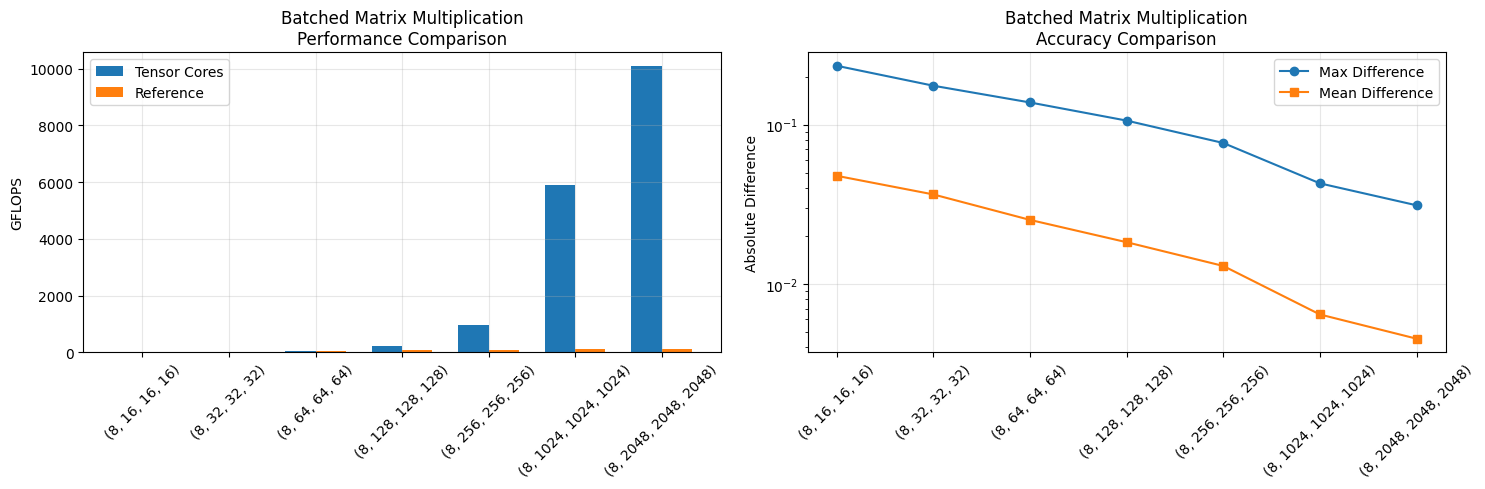

In [4]:
import numpy as np
import cupy as cp
from tensor_matrix_ops import TensorMatrixOps

def test_batched_matmul():
    """Benchmark batched matrix multiplication operations."""
    # Initialize TensorMatrixOps
    tensor_ops = TensorMatrixOps()
    
    # Operation name
    operation_name = "Batched Matrix Multiplication"
    
    # Shapes to test (batch_size, m, k, n)
    shapes = [
        (8, 16, 16, 16),
        (8, 32, 32, 32),
        (8, 64, 64, 64),
        (8, 128, 128, 128),
        (8, 256, 256, 256),
        (8, 1024, 1024, 1024),
        (8, 2048, 2048, 2048)
    ]
    
    # Create input data function
    def create_inputs(shape):
        """Create random batched matrices for matrix multiplication."""
        batch_size, m, k, n = shape
        
        # Create inputs in the format expected by tensor_ops.batched_matmul
        a = cp.asfortranarray(cp.random.random((batch_size, m, k), dtype=cp.float64))
        b = cp.asfortranarray(cp.random.random((batch_size, k, n), dtype=cp.float64))
        
        # Scale to prevent numerical overflow
        a /= (cp.sqrt(k) * 1.1)
        b /= (cp.sqrt(k) * 1.1)
        
        return [a, b]
    
    # Calculate FLOPS
    def calculate_flops(shape):
        """Calculate FLOPS for batched matrix multiplication."""
        batch_size, m, k, n = shape
        # Batched matrix multiplication requires 2*batch_size*M*N*K FLOPS
        return 2 * batch_size * m * n * k
    
    # Define tensor operation
    def tensor_op(a, b):
        return tensor_ops.batched_matmul(a, b)
    
    # Define reference operation (using cupy's batch matmul)
    def reference_op(a, b):
        return cp.matmul(a, b)
    
    # Run the benchmark
    results = run_benchmark(
        operation_name,
        tensor_op,
        reference_op,
        shapes,
        create_inputs,
        calculate_flops
    )
    
    return results

if __name__ == "__main__":
    test_batched_matmul()
    cleanup()

Initializing CUDA...
CUDA initialization complete
Function signatures configured

Benchmarking Vector-Matrix Multiplication...

Shape: 16

Shape: 32

Shape: 64

Shape: 128

Shape: 256

Shape: 512

Shape: 768

Shape: 1024

Results for Vector-Matrix Multiplication

Performance Comparison:
--------------------------------------------------------------------------------
Shape                       Tensor GFLOPS Reference GFLOPS      Speedup     Max Diff    Mean Diff
--------------------------------------------------------------------------------
16                                   0.04            0.01         5.38     7.58e-02     3.20e-02
32                                   0.15            0.02         6.39     6.70e-02     2.70e-02
64                                   0.54            0.12         4.49     6.27e-02     2.05e-02
128                                  1.48            0.53         2.79     4.82e-02     1.33e-02
256                                  4.30            2.22       

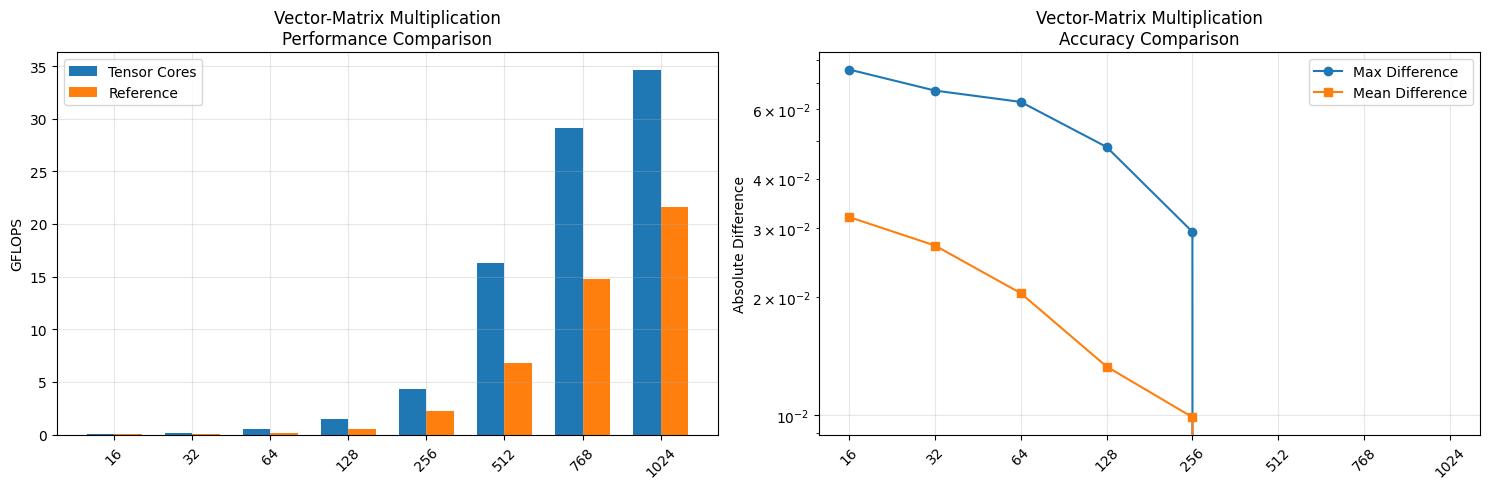

In [5]:
import numpy as np
import cupy as cp
from tensor_matrix_ops import TensorMatrixOps

def test_vector_matrix():
    """Benchmark vector-matrix multiplication (v*A) operations."""
    # Initialize TensorMatrixOps
    tensor_ops = TensorMatrixOps()
    
    # Operation name
    operation_name = "Vector-Matrix Multiplication"
    
    # Sizes to test (n for n×n matrices)
    sizes = [16, 32, 64, 128, 256, 512, 768, 1024]
    
    # Create input data function
    def create_inputs(size):
        """Create a random vector and matrix in Fortran order."""
        v = cp.asfortranarray(cp.random.random(size, dtype=cp.float64))
        a = cp.asfortranarray(cp.random.random((size, size), dtype=cp.float64))
        
        # Scale to prevent numerical overflow
        v /= (cp.sqrt(size) * 1.1)
        a /= (cp.sqrt(size) * 1.1)
        
        return [v, a]
    
    # Calculate FLOPS
    def calculate_flops(size):
        """Calculate FLOPS for vector-matrix multiplication."""
        n = size
        # Vector-matrix multiplication requires 2*n*n FLOPS
        return 2 * n * n
    
    # Define tensor operation
    def tensor_op(v, a):
        return tensor_ops.vector_matmul(v, a)
    
    # Define reference operation
    def reference_op(v, a):
        # Vector-matrix multiplication is v @ A
        return cp.matmul(v, a)
    
    # Run the benchmark
    results = run_benchmark(
        operation_name,
        tensor_op,
        reference_op,
        sizes,
        create_inputs,
        calculate_flops
    )
    
    return results

if __name__ == "__main__":
    test_vector_matrix()



Initializing CUDA...
CUDA initialization complete
Function signatures configured

Benchmarking Vector-Matrix Optimised Multiplication...

Shape: 16

Shape: 32

Shape: 64

Shape: 128

Shape: 256

Shape: 512

Shape: 768

Shape: 1024

Results for Vector-Matrix Optimised Multiplication

Performance Comparison:
--------------------------------------------------------------------------------
Shape                       Tensor GFLOPS Reference GFLOPS      Speedup     Max Diff    Mean Diff
--------------------------------------------------------------------------------
16                                   0.03            0.01         5.26     8.29e-02     3.59e-02
32                                   0.16            0.03         5.09     5.96e-02     1.86e-02
64                                   0.55            0.14         4.05     6.62e-02     2.00e-02
128                                  1.70            0.58         2.92     5.75e-02     1.42e-02
256                                  4.11   

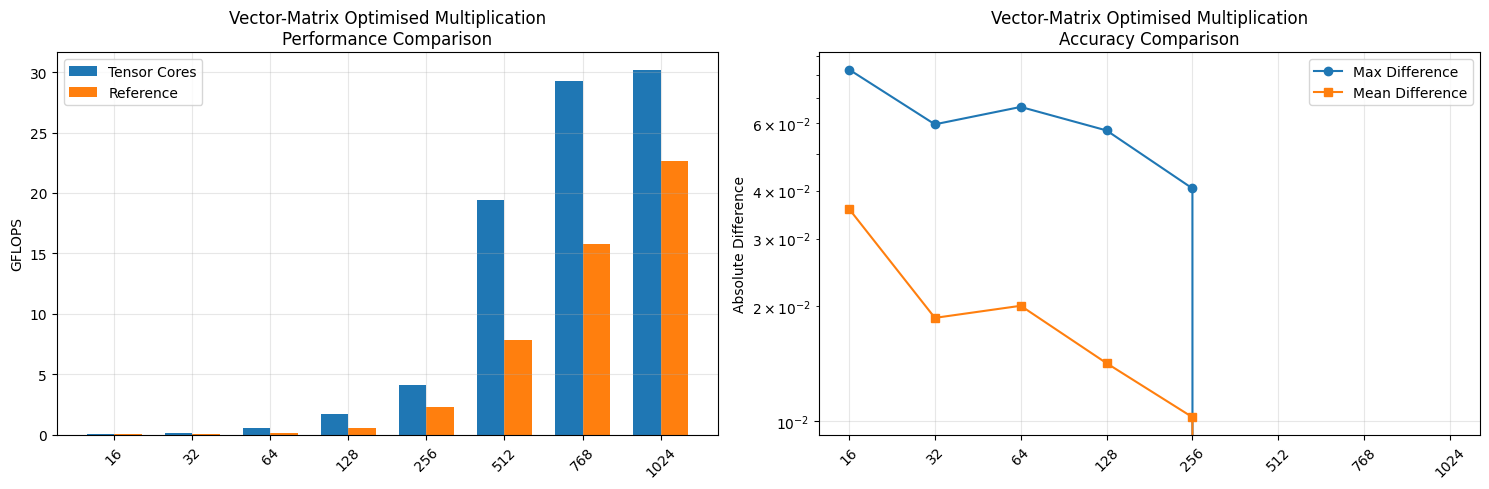

In [6]:
import numpy as np
import cupy as cp
from tensor_matrix_ops import TensorMatrixOps

def test_vector_matrix():
    """Benchmark vector-matrix multiplication (v*A) operations."""
    # Initialize TensorMatrixOps
    tensor_ops = TensorMatrixOps()
    
    # Operation name
    operation_name = "Vector-Matrix Optimised Multiplication"
    
    # Sizes to test (n for n×n matrices)
    sizes = [16, 32, 64, 128, 256, 512, 768, 1024]
    
    # Create input data function
    def create_inputs(size):
        """Create a random vector and matrix in Fortran order."""
        v = cp.asfortranarray(cp.random.random(size, dtype=cp.float64))
        a = cp.asfortranarray(cp.random.random((size, size), dtype=cp.float64))
        
        # Scale to prevent numerical overflow
        v /= (cp.sqrt(size) * 1.1)
        a /= (cp.sqrt(size) * 1.1)
        
        return [v, a]
    
    # Calculate FLOPS
    def calculate_flops(size):
        """Calculate FLOPS for vector-matrix multiplication."""
        n = size
        # Vector-matrix multiplication requires 2*n*n FLOPS
        return 2 * n * n
    
    # Define tensor operation
    def tensor_op(v, a):
        return tensor_ops.vector_matmul(v, a)
    
    # Define reference operation
    def reference_op(v, a):
        # Vector-matrix multiplication is v @ A
        return cp.matmul(v, a)
    
    # Run the benchmark
    results = run_benchmark(
        operation_name,
        tensor_op,
        reference_op,
        sizes,
        create_inputs,
        calculate_flops
    )
    
    return results

if __name__ == "__main__":
    test_vector_matrix()

Initializing CUDA...
CUDA initialization complete
Function signatures configured

Benchmarking Matrix-Vector Multiplication...

Shape: 16

Shape: 32

Shape: 64

Shape: 128

Shape: 256

Shape: 512

Shape: 768

Shape: 1024

Results for Matrix-Vector Multiplication

Performance Comparison:
--------------------------------------------------------------------------------
Shape                       Tensor GFLOPS Reference GFLOPS      Speedup     Max Diff    Mean Diff
--------------------------------------------------------------------------------
16                                   0.04            0.01         5.04     0.00e+00     0.00e+00
32                                   0.16            0.03         4.69     8.33e-17     1.82e-17
64                                   0.53            0.13         4.10     1.11e-16     3.21e-17
128                                  1.60            0.58         2.76     1.67e-16     5.79e-17
256                                  4.31            2.35       

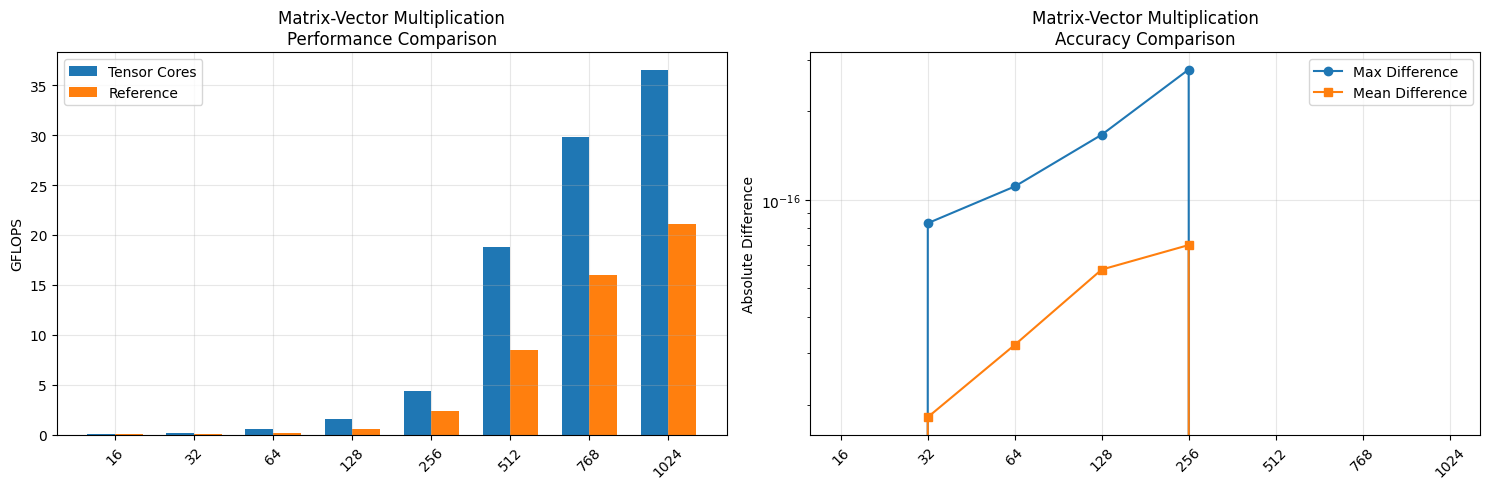

In [7]:
import numpy as np
import cupy as cp
from tensor_matrix_ops import TensorMatrixOps

def test_matrix_vector():
    """Benchmark matrix-vector multiplication (A*v) operations."""
    # Initialize TensorMatrixOps
    tensor_ops = TensorMatrixOps()
    
    # Operation name
    operation_name = "Matrix-Vector Multiplication"
    
    # Sizes to test (n for n×n matrices)
    sizes = [16, 32, 64, 128, 256, 512, 768, 1024]
    
    # Create input data function
    def create_inputs(size):
        """Create a random matrix and vector in Fortran order."""
        a = cp.asfortranarray(cp.random.random((size, size), dtype=cp.float64))
        v = cp.asfortranarray(cp.random.random(size, dtype=cp.float64))
        
        # Scale to prevent numerical overflow
        a /= (cp.sqrt(size) * 1.1)
        v /= (cp.sqrt(size) * 1.1)
        
        return [a, v]
    
    # Calculate FLOPS
    def calculate_flops(size):
        """Calculate FLOPS for matrix-vector multiplication."""
        n = size
        # Matrix-vector multiplication requires 2*n*n FLOPS
        return 2 * n * n
    
    # Define tensor operation
    def tensor_op(a, v):
        return tensor_ops.matmul_vector(a, v)
    
    # Define reference operation
    def reference_op(a, v):
        # Matrix-vector multiplication is A @ v
        return cp.matmul(a, v)
    
    # Run the benchmark
    results = run_benchmark(
        operation_name,
        tensor_op,
        reference_op,
        sizes,
        create_inputs,
        calculate_flops
    )
    
    return results

if __name__ == "__main__":
    test_matrix_vector()

Initializing CUDA...
CUDA initialization complete
Function signatures configured

Benchmarking Batched Vector Multiplication...

Shape: (16, 10)

Shape: (32, 10)

Shape: (64, 10)

Shape: (128, 8)

Shape: (256, 4)

Shape: (512, 2)

Results for Batched Vector Multiplication

Performance Comparison:
--------------------------------------------------------------------------------
Shape                       Tensor GFLOPS Reference GFLOPS      Speedup     Max Diff    Mean Diff
--------------------------------------------------------------------------------
(16, 10)                             0.10            0.01        11.60     4.23e+00     3.56e-01
(32, 10)                             0.48            0.04        12.66     6.03e+00     7.58e-02
(64, 10)                             1.87            0.15        12.57     8.34e-01     1.81e-01
(128, 8)                             4.54            0.53         8.57     8.33e-17     1.88e-17
(256, 4)                             8.78            2

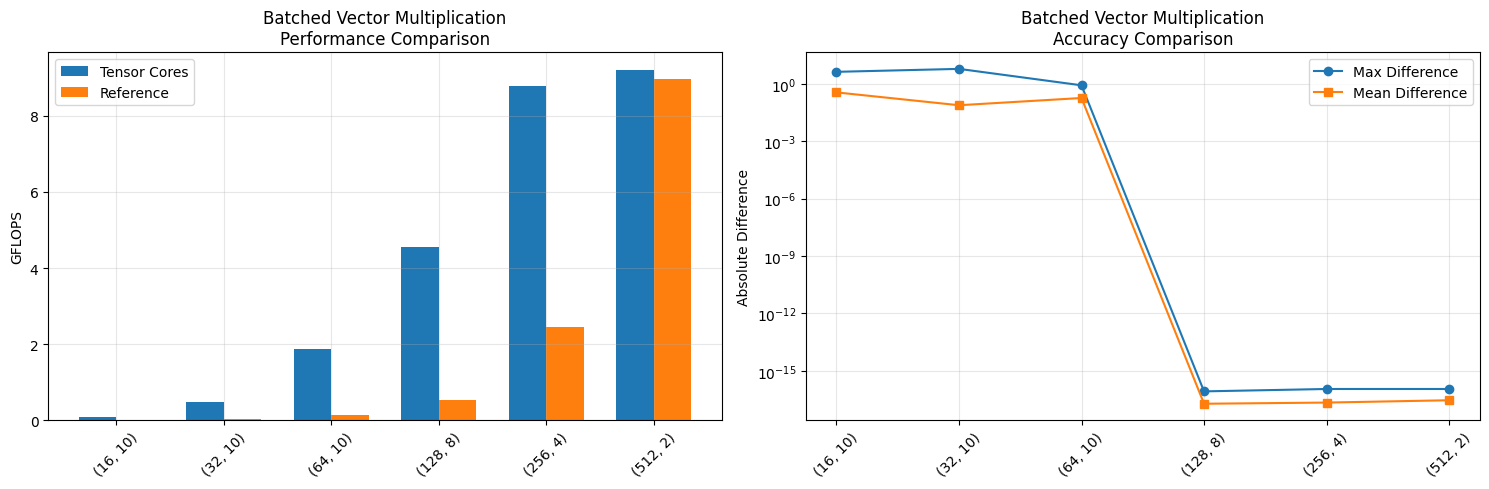

In [8]:
import numpy as np
import cupy as cp
from tensor_matrix_ops import TensorMatrixOps

def test_batched_vector():
    """Benchmark batched vector multiplication operations."""
    # Initialize TensorMatrixOps
    tensor_ops = TensorMatrixOps()
    
    # Operation name
    operation_name = "Batched Vector Multiplication"
    
    # Shapes to test (size, batch_size)
    shapes = [
        (16, 10),
        (32, 10),
        (64, 10),
        (128, 8),
        (256, 4),
        (512, 2)
    ]
    
    # Create input data function
    def create_inputs(shape):
        """Create random vectors and matrix in Fortran order."""
        size, batch_size = shape
        
        # Create batch of vectors (size, batch_size) in Fortran order
        v = cp.asfortranarray(cp.random.random((size, batch_size), dtype=cp.float64))
        
        # Create matrix (size, size) in Fortran order
        a = cp.asfortranarray(cp.random.random((size, size), dtype=cp.float64))
        
        # Scale to prevent numerical overflow
        v /= (cp.sqrt(size) * 1.1)
        a /= (cp.sqrt(size) * 1.1)
        
        return [v, a]
    
    # Calculate FLOPS
    def calculate_flops(shape):
        """Calculate FLOPS for batched vector multiplication."""
        size, batch_size = shape
        # Batched vector-matrix multiplication requires 2*size*size*batch_size FLOPS
        return 2 * size * size * batch_size
    
    # Define tensor operation
    def tensor_op(v, a):
        return tensor_ops.batched_vector_matmul(v, a)
    
    # Define reference operation
    def reference_op(v, a):
        # Manual implementation of batched vector-matrix multiplication
        size, batch_size = v.shape
        result = cp.empty((batch_size, size), dtype=cp.float64)
        
        for i in range(batch_size):
            result[i] = cp.matmul(a, v[:, i])
            
        return result
    
    # Run the benchmark
    results = run_benchmark(
        operation_name,
        tensor_op,
        reference_op,
        shapes,
        create_inputs,
        calculate_flops
    )
    
    return results

if __name__ == "__main__":
    test_batched_vector()

Initializing CUDA...
CUDA initialization complete
Function signatures configured

Benchmarking Strided Batch Matrix Multiplication...

Shape: (8, 16, 16, 16)

Shape: (8, 32, 32, 32)

Shape: (8, 64, 64, 64)

Shape: (8, 128, 128, 128)

Shape: (8, 256, 256, 256)

Shape: (8, 512, 512, 512)

Shape: (8, 1024, 1024, 1024)

Shape: (8, 2048, 2048, 2048)

Results for Strided Batch Matrix Multiplication

Performance Comparison:
--------------------------------------------------------------------------------
Shape                       Tensor GFLOPS Reference GFLOPS      Speedup     Max Diff    Mean Diff
--------------------------------------------------------------------------------
(8, 16, 16, 16)                      0.57            0.74         0.77     2.32e-01     4.99e-02
(8, 32, 32, 32)                      4.16            5.12         0.81     1.60e-01     3.56e-02
(8, 64, 64, 64)                     30.90           35.89         0.86     1.20e-01     2.53e-02
(8, 128, 128, 128)          

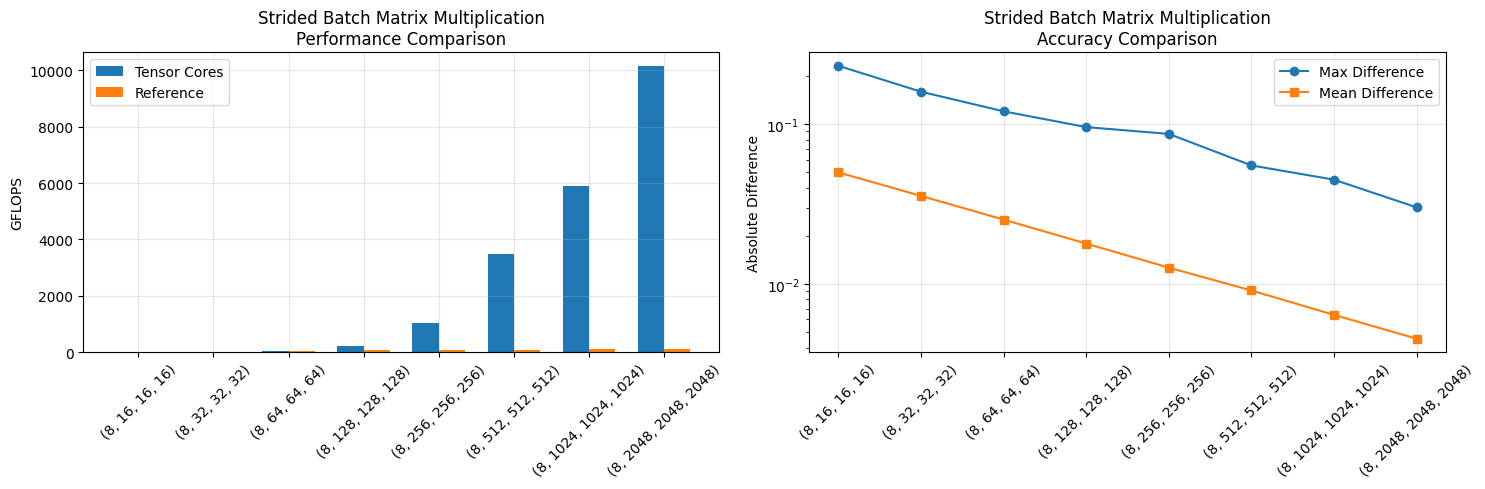

In [9]:
import numpy as np
import cupy as cp
from tensor_matrix_ops import TensorMatrixOps

def test_strided_batch():
    """Benchmark strided batch matrix multiplication operations."""
    # Initialize TensorMatrixOps
    tensor_ops = TensorMatrixOps()
    
    # Operation name
    operation_name = "Strided Batch Matrix Multiplication"
    
    # Shapes to test (batch_size, m, k, n)
    shapes = [
        (8, 16, 16, 16),
        (8, 32, 32, 32),
        (8, 64, 64, 64),
        (8, 128, 128, 128),
        (8, 256, 256, 256),
        (8, 512, 512, 512),
        (8, 1024, 1024, 1024),
        (8, 2048, 2048, 2048)
    ]
    
    # Create input data function
    def create_inputs(shape):
        """Create random matrices for strided batch matrix multiplication."""
        batch_size, m, k, n = shape
        
        # Create inputs in the correct format and memory layout
        a = cp.asfortranarray(cp.random.random((batch_size, m, k), dtype=cp.float64))
        b = cp.asfortranarray(cp.random.random((batch_size, k, n), dtype=cp.float64))
        
        # Scale to prevent numerical overflow
        a /= (cp.sqrt(k) * 1.1)
        b /= (cp.sqrt(k) * 1.1)
        
        # Prepare extra parameters needed for strided_batch_matmul
        return [m, k, n, batch_size, a, b]
    
    # Calculate FLOPS
    def calculate_flops(shape):
        """Calculate FLOPS for strided batch matrix multiplication."""
        batch_size, m, k, n = shape
        # Strided batch matrix multiplication requires 2*batch_size*m*n*k FLOPS
        return 2 * batch_size * m * n * k
    
    # Define tensor operation
    def tensor_op(m, k, n, batch_size, a, b):
        return tensor_ops.strided_batch_matmul(m, k, n, batch_size, a, b)
    
    # Define reference operation
    def reference_op(m, k, n, batch_size, a, b):
        # Standard batch matmul for comparison
        return cp.matmul(a, b)
    
    # Run the benchmark
    results = run_benchmark(
        operation_name,
        tensor_op,
        reference_op,
        shapes,
        create_inputs,
        calculate_flops
    )
    
    return results

if __name__ == "__main__":
    test_strided_batch()


Running Matrix Power Test
Initializing CUDA...
CUDA initialization complete
Function signatures configured

Benchmarking Matrix Power...

Shape: (16, 16)

Shape: (32, 32)

Shape: (64, 64)

Shape: (128, 128)

Shape: (256, 256)

Shape: (512, 512)

Shape: (768, 768)

Shape: (1024, 1024)

Shape: (2048, 2048)

Shape: (4048, 4048)

Shape: (8192, 8192)
Error testing shape (8192, 8192): Out of memory allocating 536,870,912 bytes (allocated so far: 2,147,483,648 bytes).

Results for Matrix Power

Performance Comparison:
--------------------------------------------------------------------------------
Shape                       Tensor GFLOPS Reference GFLOPS      Speedup     Max Diff    Mean Diff
--------------------------------------------------------------------------------
(16, 16)                             0.64            0.17         3.80     9.16e-08     2.45e-08
(32, 32)                             4.41            1.45         3.04     6.13e-07     1.15e-07
(64, 64)                    

Traceback (most recent call last):
  File "/tmp/ipykernel_87232/2609331069.py", line 188, in run_benchmark
    reference_result, reference_times = time_operation(reference_op, *inputs)
                                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_87232/2609331069.py", line 25, in time_operation
    result = operation(*args)
             ^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_87232/3576072830.py", line 54, in reference_op
    return cp.linalg.matrix_power(a, p)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/home/fraser/anaconda3/envs/py312/lib/python3.12/site-packages/cupy/linalg/_product.py", line 375, in matrix_power
    Z = M if Z is None else cupy.matmul(Z, Z)
                            ^^^^^^^^^^^^^^^^^
  File "/var/home/fraser/anaconda3/envs/py312/lib/python3.12/site-packages/cupy/_core/_gufuncs.py", line 669, in __call__
    outs = cupy.empty(out_shape, dtype=ret_dtype, order=filter_order)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

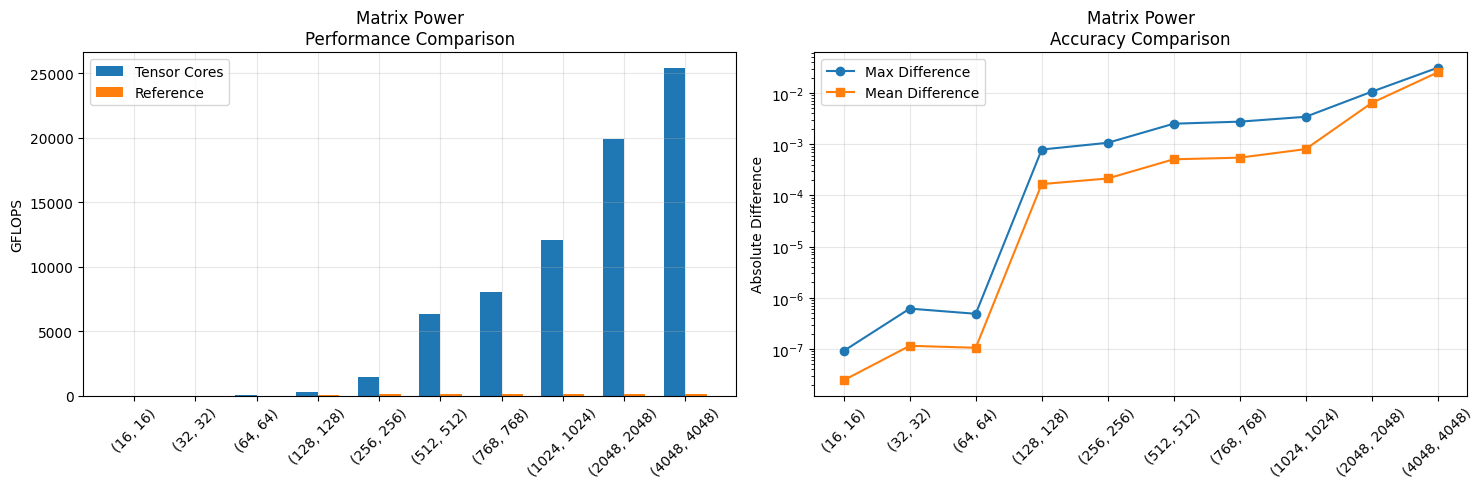


Running Matrix Multiplication Test
Initializing CUDA...
CUDA initialization complete
Function signatures configured

Benchmarking Matrix Multiplication...

Shape: (16, 16, 16)

Shape: (32, 32, 32)

Shape: (64, 64, 64)

Shape: (128, 128, 128)

Shape: (256, 256, 256)

Shape: (512, 512, 512)

Shape: (640, 640, 640)

Shape: (1024, 1024, 1024)

Shape: (2048, 2048, 2048)

Shape: (4048, 4048, 4048)

Shape: (7192, 7192, 7192)
Error testing shape (7192, 7192, 7192): Out of memory allocating 413,798,912 bytes (allocated so far: 2,192,066,560 bytes).

Results for Matrix Multiplication

Performance Comparison:
--------------------------------------------------------------------------------
Shape                       Tensor GFLOPS Reference GFLOPS      Speedup     Max Diff    Mean Diff
--------------------------------------------------------------------------------
(16, 16, 16)                         0.19            0.06         3.07     2.88e-08     7.39e-09
(32, 32, 32)                        

Traceback (most recent call last):
  File "/tmp/ipykernel_87232/2609331069.py", line 191, in run_benchmark
    metrics = calculate_metrics(
              ^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_87232/2609331069.py", line 54, in calculate_metrics
    max_diff = float(cp.max(cp.abs(tensor_result - reference_result)))
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "cupy/_core/_kernel.pyx", line 1350, in cupy._core._kernel.ufunc.__call__
  File "cupy/_core/_kernel.pyx", line 645, in cupy._core._kernel._get_out_args_from_optionals
  File "cupy/_core/core.pyx", line 2836, in cupy._core.core._ndarray_init
  File "cupy/_core/core.pyx", line 243, in cupy._core.core._ndarray_base._init_fast
  File "cupy/cuda/memory.pyx", line 738, in cupy.cuda.memory.alloc
  File "cupy/cuda/memory.pyx", line 1424, in cupy.cuda.memory.MemoryPool.malloc
  File "cupy/cuda/memory.pyx", line 1445, in cupy.cuda.memory.MemoryPool.malloc
  File "cupy/cuda/memory.pyx", line 1116, in cupy.cu

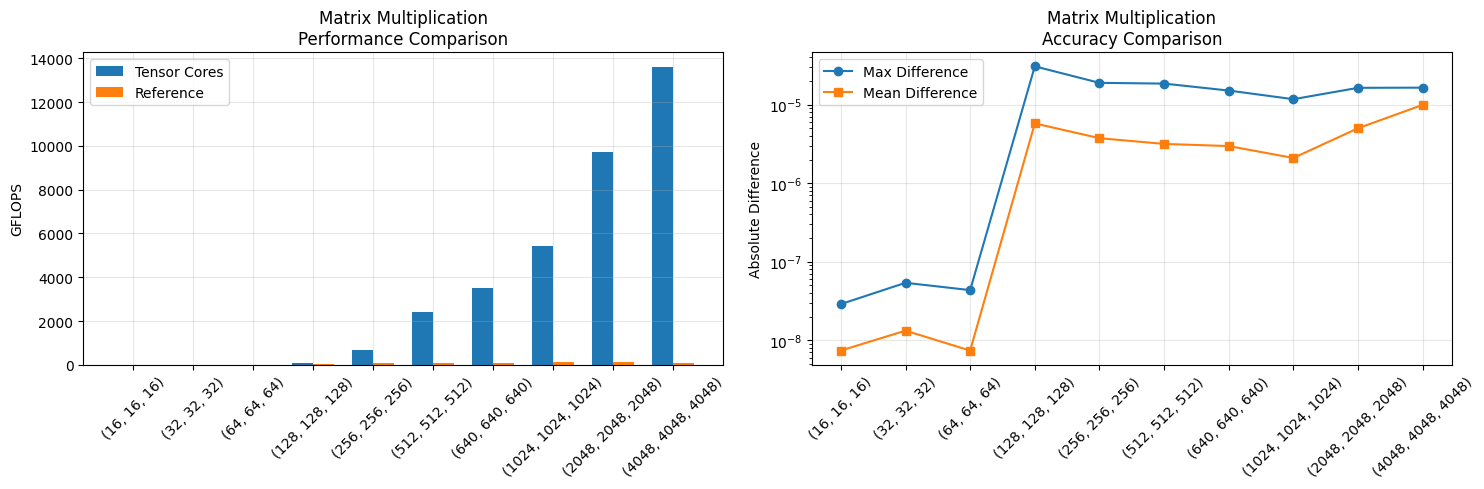


Running Batched Matrix Multiplication Test
Initializing CUDA...
CUDA initialization complete
Function signatures configured

Benchmarking Batched Matrix Multiplication...

Shape: (8, 16, 16, 16)

Shape: (8, 32, 32, 32)

Shape: (8, 64, 64, 64)

Shape: (8, 128, 128, 128)

Shape: (8, 256, 256, 256)

Shape: (8, 1024, 1024, 1024)

Shape: (8, 2048, 2048, 2048)

Results for Batched Matrix Multiplication

Performance Comparison:
--------------------------------------------------------------------------------
Shape                       Tensor GFLOPS Reference GFLOPS      Speedup     Max Diff    Mean Diff
--------------------------------------------------------------------------------
(8, 16, 16, 16)                      0.46            0.68         0.67     2.75e-01     5.10e-02
(8, 32, 32, 32)                      3.55            5.29         0.67     1.73e-01     3.56e-02
(8, 64, 64, 64)                     25.96           30.92         0.84     1.28e-01     2.49e-02
(8, 128, 128, 128)     

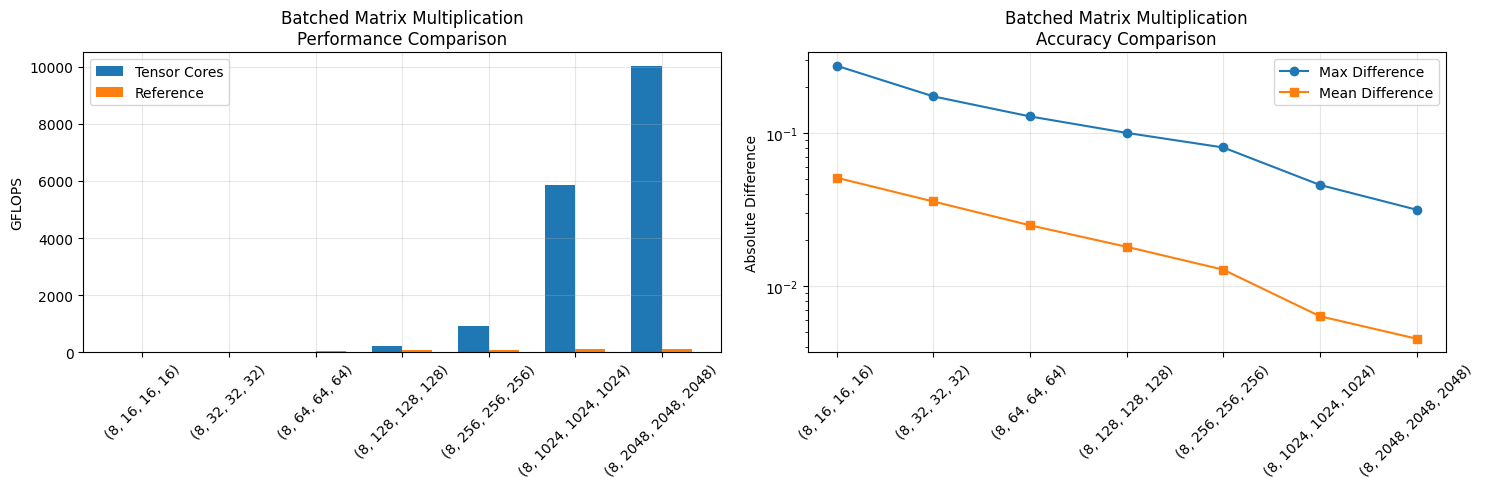


Running Vector-Matrix Multiplication Test
Initializing CUDA...
CUDA initialization complete
Function signatures configured

Benchmarking Vector-Matrix Optimised Multiplication...

Shape: 16

Shape: 32

Shape: 64

Shape: 128

Shape: 256

Shape: 512

Shape: 768

Shape: 1024

Results for Vector-Matrix Optimised Multiplication

Performance Comparison:
--------------------------------------------------------------------------------
Shape                       Tensor GFLOPS Reference GFLOPS      Speedup     Max Diff    Mean Diff
--------------------------------------------------------------------------------
16                                   0.02            0.01         3.50     5.91e-02     3.62e-02
32                                   0.15            0.03         4.46     6.20e-02     2.60e-02
64                                   0.52            0.13         3.87     5.35e-02     1.87e-02
128                                  1.55            0.39         3.99     4.24e-02     1.49e-02
2

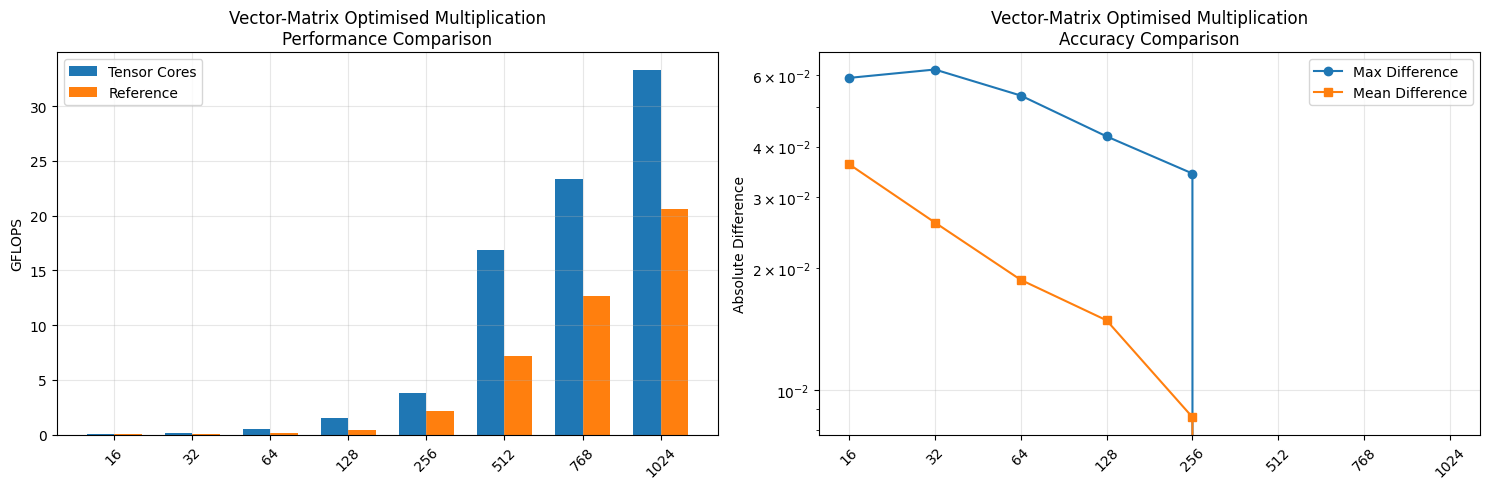


Running Matrix-Vector Multiplication Test
Initializing CUDA...
CUDA initialization complete
Function signatures configured

Benchmarking Matrix-Vector Multiplication...

Shape: 16

Shape: 32

Shape: 64

Shape: 128

Shape: 256

Shape: 512

Shape: 768

Shape: 1024

Results for Matrix-Vector Multiplication

Performance Comparison:
--------------------------------------------------------------------------------
Shape                       Tensor GFLOPS Reference GFLOPS      Speedup     Max Diff    Mean Diff
--------------------------------------------------------------------------------
16                                   0.03            0.01         4.26     0.00e+00     0.00e+00
32                                   0.16            0.04         4.03     5.55e-17     2.43e-17
64                                   0.49            0.17         2.95     1.11e-16     2.99e-17
128                                  1.71            0.45         3.79     1.94e-16     4.66e-17
256                  

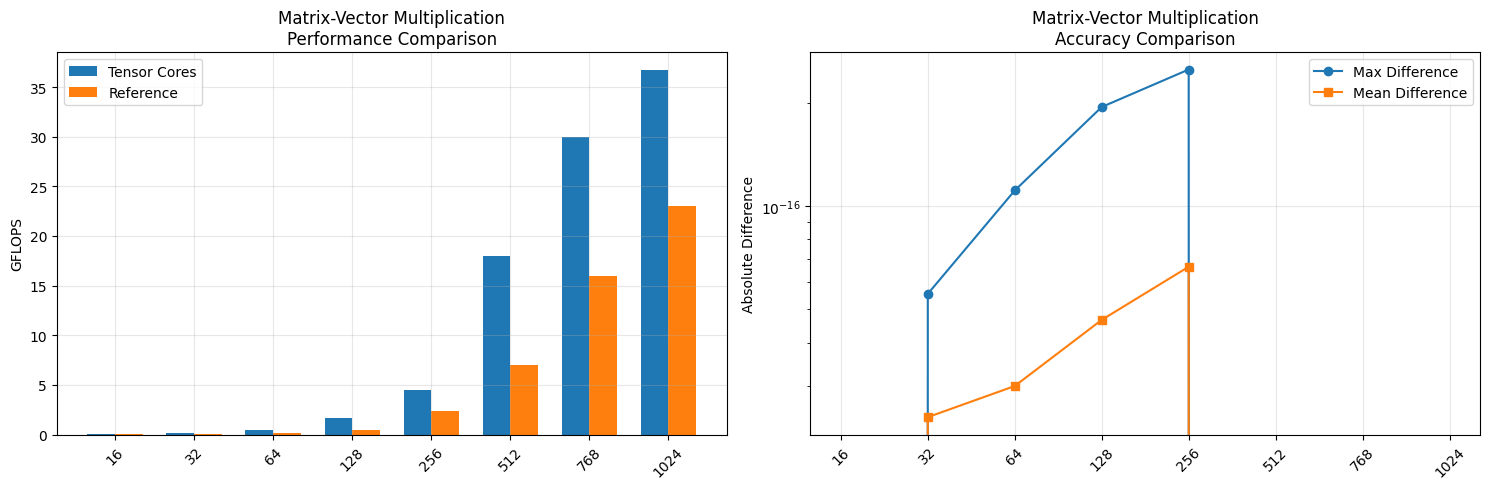


Running Batched Vector Multiplication Test
Initializing CUDA...
CUDA initialization complete
Function signatures configured

Benchmarking Batched Vector Multiplication...

Shape: (16, 10)

Shape: (32, 10)

Shape: (64, 10)

Shape: (128, 8)

Shape: (256, 4)

Shape: (512, 2)

Results for Batched Vector Multiplication

Performance Comparison:
--------------------------------------------------------------------------------
Shape                       Tensor GFLOPS Reference GFLOPS      Speedup     Max Diff    Mean Diff
--------------------------------------------------------------------------------
(16, 10)                             0.11            0.01        13.52     4.20e+00     3.59e-01
(32, 10)                             0.45            0.04        11.79     6.03e+00     2.39e-01
(64, 10)                             1.63            0.15        10.79     8.30e-01     3.34e-01
(128, 8)                             5.58            0.60         9.25     8.33e-17     1.98e-17
(256, 4)  

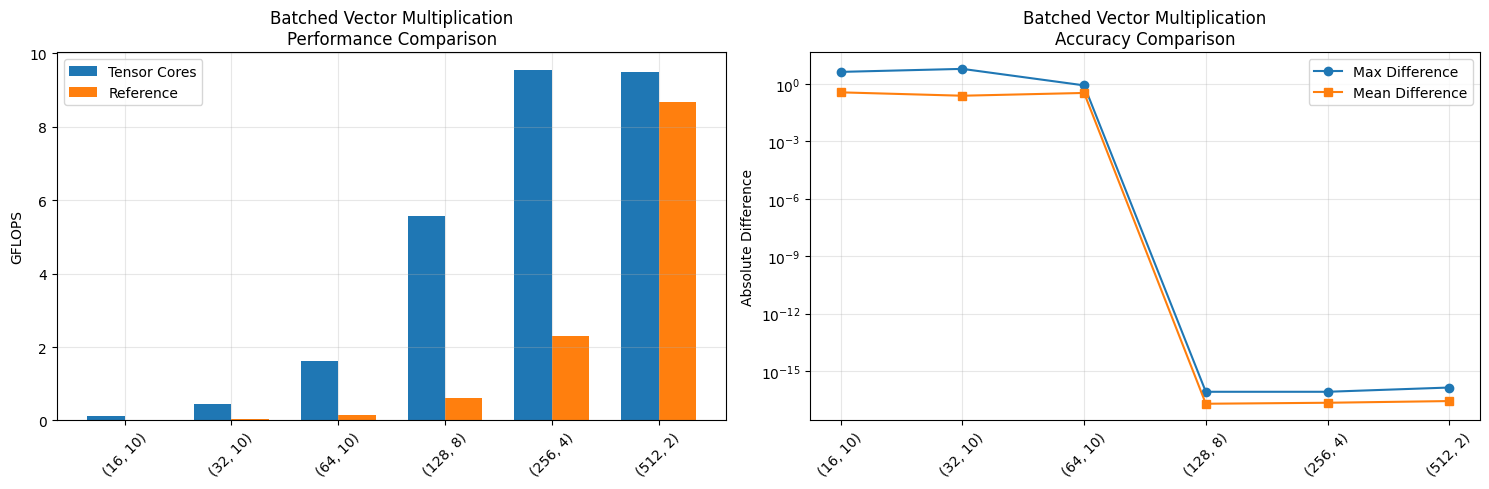


Running Strided Batch Matrix Multiplication Test
Initializing CUDA...
CUDA initialization complete
Function signatures configured

Benchmarking Strided Batch Matrix Multiplication...

Shape: (8, 16, 16, 16)

Shape: (8, 32, 32, 32)

Shape: (8, 64, 64, 64)

Shape: (8, 128, 128, 128)

Shape: (8, 256, 256, 256)

Shape: (8, 512, 512, 512)

Shape: (8, 1024, 1024, 1024)

Shape: (8, 2048, 2048, 2048)

Results for Strided Batch Matrix Multiplication

Performance Comparison:
--------------------------------------------------------------------------------
Shape                       Tensor GFLOPS Reference GFLOPS      Speedup     Max Diff    Mean Diff
--------------------------------------------------------------------------------
(8, 16, 16, 16)                      0.40            0.65         0.62     2.47e-01     4.98e-02
(8, 32, 32, 32)                      4.09            5.01         0.82     1.72e-01     3.68e-02
(8, 64, 64, 64)                     33.30           31.57         1.05     

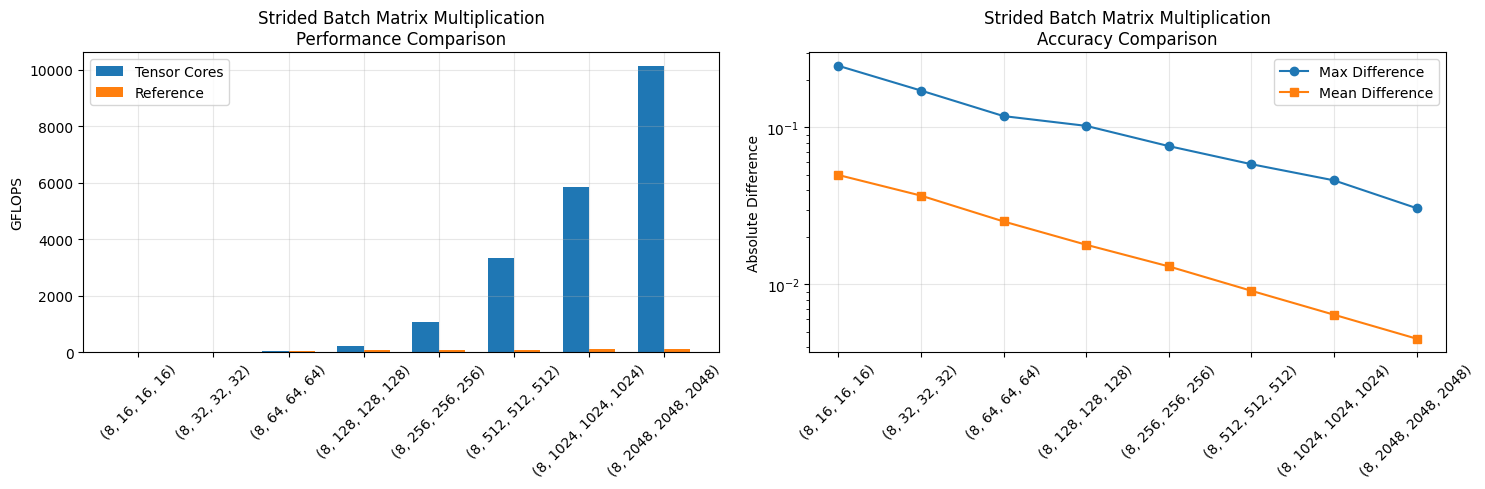


All benchmarks completed in 78.11 seconds

Summary of All Benchmarks:
----------------------------------------------------------------------------------------------------
Operation                      Shape                  Tensor GFLOPS Reference GFLOPS    Speedup   Max Diff
----------------------------------------------------------------------------------------------------
Matrix Power                   (16, 16)                        0.64            0.17       3.80   9.16e-08
Matrix Power                   (32, 32)                        4.41            1.45       3.04   6.13e-07
Matrix Power                   (64, 64)                       33.66            7.71       4.36   4.86e-07
Matrix Power                   (128, 128)                    268.16           79.54       3.37   7.87e-04
Matrix Power                   (256, 256)                   1483.35          142.67      10.40   1.07e-03
Matrix Power                   (512, 512)                   6344.84          151.03      4

In [10]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt


def run_all_tests():
    """Run all matrix operation benchmarks with proper cleanup between tests."""
    tests = [
        ("Matrix Power", test_matrix_power),
        ("Matrix Multiplication", test_matrix_multiply),
        ("Batched Matrix Multiplication", test_batched_matmul),
        ("Vector-Matrix Multiplication", test_vector_matrix),
        ("Matrix-Vector Multiplication", test_matrix_vector),
        ("Batched Vector Multiplication", test_batched_vector), 
        ("Strided Batch Matrix Multiplication", test_strided_batch)
    ]
    
    all_results = {}
    start_time = time.time()
    
    for name, test_func in tests:
        print(f"\n{'=' * 80}")
        print(f"Running {name} Test")
        print(f"{'=' * 80}")
        
        try:
            # Run the test
            results = test_func()
            all_results[name] = results
            
            # Cleanup after each test
            cleanup()
            
        except Exception as e:
            print(f"Error in {name}: {e}")
            import traceback
            traceback.print_exc()
    
    end_time = time.time()
    print(f"\n{'=' * 80}")
    print(f"All benchmarks completed in {end_time - start_time:.2f} seconds")
    print(f"{'=' * 80}")
    
    return all_results

def generate_summary_report(all_results):
    """Generate a summary report of all benchmark results."""
    print("\nSummary of All Benchmarks:")
    print(f"{'-' * 100}")
    print(f"{'Operation':30} {'Shape':20} {'Tensor GFLOPS':>15} {'Reference GFLOPS':>15} {'Speedup':>10} {'Max Diff':>10}")
    print(f"{'-' * 100}")
    
    # Loop through all results
    for operation, results in all_results.items():
        for r in results:
            shape_str = str(r['shape'])
            print(f"{operation:30} {shape_str:20} {r['tensor_gflops']:15.2f} {r['reference_gflops']:15.2f} "
                  f"{r['speedup']:10.2f} {r['max_diff']:10.2e}")

if __name__ == "__main__":
    # Run all benchmarks
    all_results = run_all_tests()
    
    # Generate summary report
    generate_summary_report(all_results)

Initializing CUDA...
CUDA initialization complete
Function signatures configured

Testing 4D Tensor Multiplication...

Shape: (2, 2, 16, 16)

Array shapes:
Input a: (2, 2, 16, 16)
Input b: (2, 2, 16, 16)
Output tensor: (2, 2, 16, 16)
Output cupy: (2, 2, 16, 16)

Shape: (4, 4, 32, 32)

Shape: (8, 8, 64, 64)

Shape: (8, 8, 128, 128)

Shape: (8, 8, 256, 256)

Shape: (8, 8, 512, 512)

Shape: (8, 8, 640, 640)

Detailed Comparison:
--------------------------------------------------------------------------------
Shape                       Tensor GFLOPS     CuPy GFLOPS     Max Diff    Mean Diff
--------------------------------------------------------------------------------
(2, 2, 16, 16)                       0.30            0.12     3.10e-08     6.52e-09
(4, 4, 32, 32)                       3.96            1.14     9.41e-08     1.36e-08
(8, 8, 64, 64)                      35.26            8.96     4.86e-08     7.21e-09
(8, 8, 128, 128)                   177.81           72.51     3.95e-05  

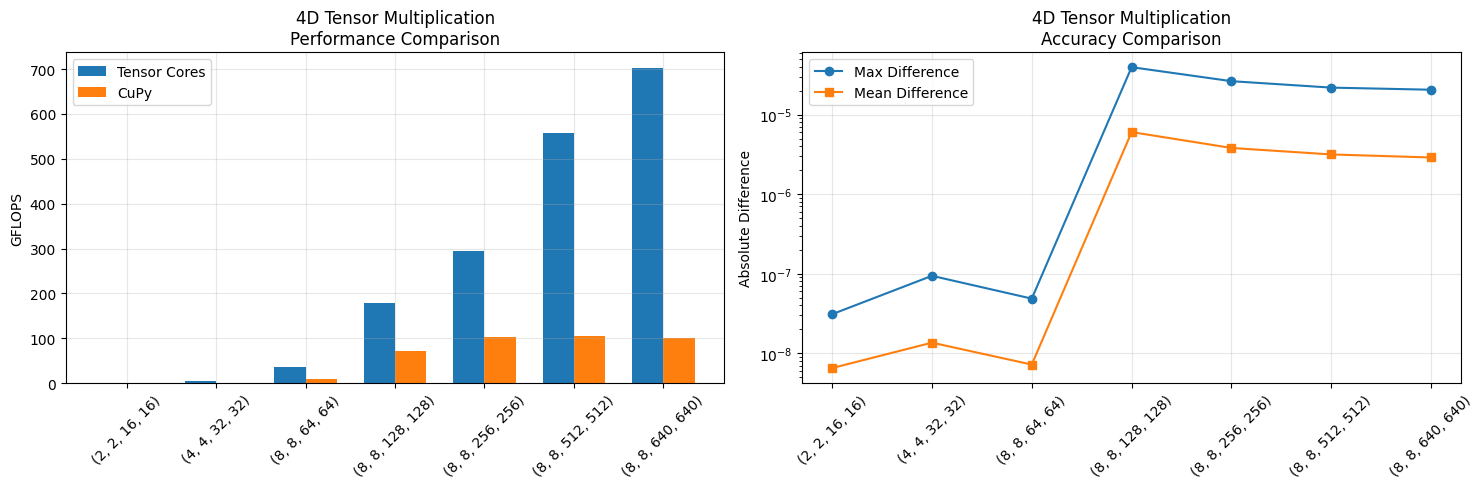

In [11]:
import numpy as np
import cupy as cp
import time
from tensor_matrix_ops import TensorMatrixOps
import matplotlib.pyplot as plt

# Cell for Tensor 4D Test
def test_tensor_4d():
    """Test 4D tensor multiplication with correct input format."""
    operation_name = "4D Tensor Multiplication"
    shapes = [
        (2, 2, 16, 16),     # (batch1, batch2, m, n)
        (4, 4, 32, 32),
        (8, 8, 64, 64),
        (8, 8, 128, 128),
        (8, 8, 256, 256),
        (8, 8, 512, 512),
        (8, 8, 640, 640)
    ]
    tensor_ops = TensorMatrixOps()
    
    print(f"\nTesting {operation_name}...")
    results = []
    
    for shape in shapes:
        print(f"\nShape: {shape}")
        try:
            batch1, batch2, m, n = shape
            
            # Create test data in format expected by tensor_4d_matmul
            a = cp.random.random((batch1, batch2, m, n), dtype=cp.float64)
            b = cp.random.random((batch1, batch2, n, n), dtype=cp.float64)
            
            # Scale inputs
            a /= (cp.sqrt(n) * 1.1)
            b /= (cp.sqrt(n) * 1.1)
            
            # Calculate FLOPS: regular matmul FLOPS * number of matmuls
            flops = 2 * m * n * n * batch1 * batch2
            
            # Time tensor core implementation
            tensor_times = []
            for i in range(3):
                cp.cuda.runtime.deviceSynchronize()
                start = time.perf_counter()
                c_tensor = tensor_ops.tensor_4d_matmul(a, b)
                cp.cuda.Stream.null.synchronize()
                elapsed = time.perf_counter() - start
                tensor_times.append(elapsed)
            
            # Time cupy implementation
            cupy_times = []
            for i in range(3):
                cp.cuda.runtime.deviceSynchronize()
                start = time.perf_counter()
                c_cupy = cp.empty((batch1, batch2, m, n), dtype=cp.float64)
                for i in range(batch1):
                    for j in range(batch2):
                        c_cupy[i,j] = cp.matmul(a[i,j], b[i,j])
                cp.cuda.Stream.null.synchronize()
                elapsed = time.perf_counter() - start
                cupy_times.append(elapsed)
            
            # Print shapes for verification
            if shape == shapes[0]:  # Only for first shape
                print("\nArray shapes:")
                print(f"Input a: {a.shape}")
                print(f"Input b: {b.shape}")
                print(f"Output tensor: {c_tensor.shape}")
                print(f"Output cupy: {c_cupy.shape}")
            
            # Compare results
            max_diff = cp.max(cp.abs(c_tensor - c_cupy))
            mean_diff = cp.mean(cp.abs(c_tensor - c_cupy))
            
            results.append({
                'shape': shape,
                'flops': flops,
                'tensor_times': tensor_times,
                'cupy_times': cupy_times,
                'tensor_gflops': flops / (min(tensor_times) * 1e9),
                'cupy_gflops': flops / (min(cupy_times) * 1e9),
                'max_diff': float(max_diff),
                'mean_diff': float(mean_diff),
                'sample_tensor': cp.asnumpy(c_tensor[0,0,:5,:5]),  # First batch, first 5x5 elements
                'sample_cupy': cp.asnumpy(c_cupy[0,0,:5,:5])      # First batch, first 5x5 elements
            })
            
            # Cleanup
            del a, b, c_tensor, c_cupy
            cp.cuda.runtime.deviceSynchronize()
            cp.get_default_memory_pool().free_all_blocks()
            
        except Exception as e:
            print(f"Error testing shape {shape}: {e}")
            import traceback
            traceback.print_exc()
            
    if results:
        print("\nDetailed Comparison:")
        print("-" * 80)
        print(f"{'Shape':25} {'Tensor GFLOPS':>15} {'CuPy GFLOPS':>15} {'Max Diff':>12} {'Mean Diff':>12}")
        print("-" * 80)
        
        for r in results:
            shape_str = str(r['shape'])
            print(f"{shape_str:25} {r['tensor_gflops']:15.2f} {r['cupy_gflops']:15.2f} "
                  f"{r['max_diff']:12.2e} {r['mean_diff']:12.2e}")
        
        print("\nSample Output Comparison (first 5x5 slice):")
        print("-" * 80)
        for r in results:
            print(f"\nShape: {r['shape']}")
            print(f"Tensor:\n{r['sample_tensor']}")
            print(f"CuPy:\n{r['sample_cupy']}")
        
        # Create plots with operation name
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Performance comparison
        x = np.arange(len(results))
        width = 0.35
        
        tensor_gflops = [r['tensor_gflops'] for r in results]
        cupy_gflops = [r['cupy_gflops'] for r in results]
        
        ax1.bar(x - width/2, tensor_gflops, width, label='Tensor Cores')
        ax1.bar(x + width/2, cupy_gflops, width, label='CuPy')
        ax1.set_ylabel('GFLOPS')
        ax1.set_title(f'{operation_name}\nPerformance Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels([str(r['shape']) for r in results], rotation=45)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Accuracy comparison
        max_diffs = [r['max_diff'] for r in results]
        mean_diffs = [r['mean_diff'] for r in results]
        
        ax2.plot(x, max_diffs, 'o-', label='Max Difference')
        ax2.plot(x, mean_diffs, 's-', label='Mean Difference')
        ax2.set_ylabel('Absolute Difference')
        ax2.set_title(f'{operation_name}\nAccuracy Comparison')
        ax2.set_xticks(x)
        ax2.set_xticklabels([str(r['shape']) for r in results], rotation=45)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_yscale('log')
        
        plt.tight_layout()
        plt.show()
    
    return results

# Run test
results = test_tensor_4d()

Starting comparison...

Testing shape: (2, 2, 2, 16, 16)
Operations: 65,536
Initializing CUDA...
CUDA initialization complete
Function signatures configured
Running tensor core tests...
Tensor Run 1: 129.34ms (0.00 GFLOPS)
Tensor Run 2: 0.73ms (0.09 GFLOPS)
Tensor Run 3: 0.33ms (0.20 GFLOPS)
Tensor Run 4: 0.30ms (0.22 GFLOPS)
Tensor Run 5: 0.32ms (0.21 GFLOPS)
Running CuPy tests...

Matrix multiplication dimensions:
a_2d shape: (8, 16, 16)
b_2d shape: (8, 16, 16)
CuPy Run 1: 60.36ms (0.00 GFLOPS)
CuPy Run 2: 0.52ms (0.13 GFLOPS)
CuPy Run 3: 0.53ms (0.12 GFLOPS)
CuPy Run 4: 0.49ms (0.13 GFLOPS)
CuPy Run 5: 0.49ms (0.13 GFLOPS)
c_cupy shape: (2, 2, 2, 16, 16)
Computing differences...

Testing shape: (4, 4, 4, 32, 32)
Operations: 4,194,304
Initializing CUDA...
CUDA initialization complete
Function signatures configured
Running tensor core tests...
Tensor Run 1: 2.22ms (1.89 GFLOPS)
Tensor Run 2: 2.26ms (1.86 GFLOPS)
Tensor Run 3: 2.21ms (1.89 GFLOPS)
Tensor Run 4: 1.94ms (2.16 GFLOPS)
Ten

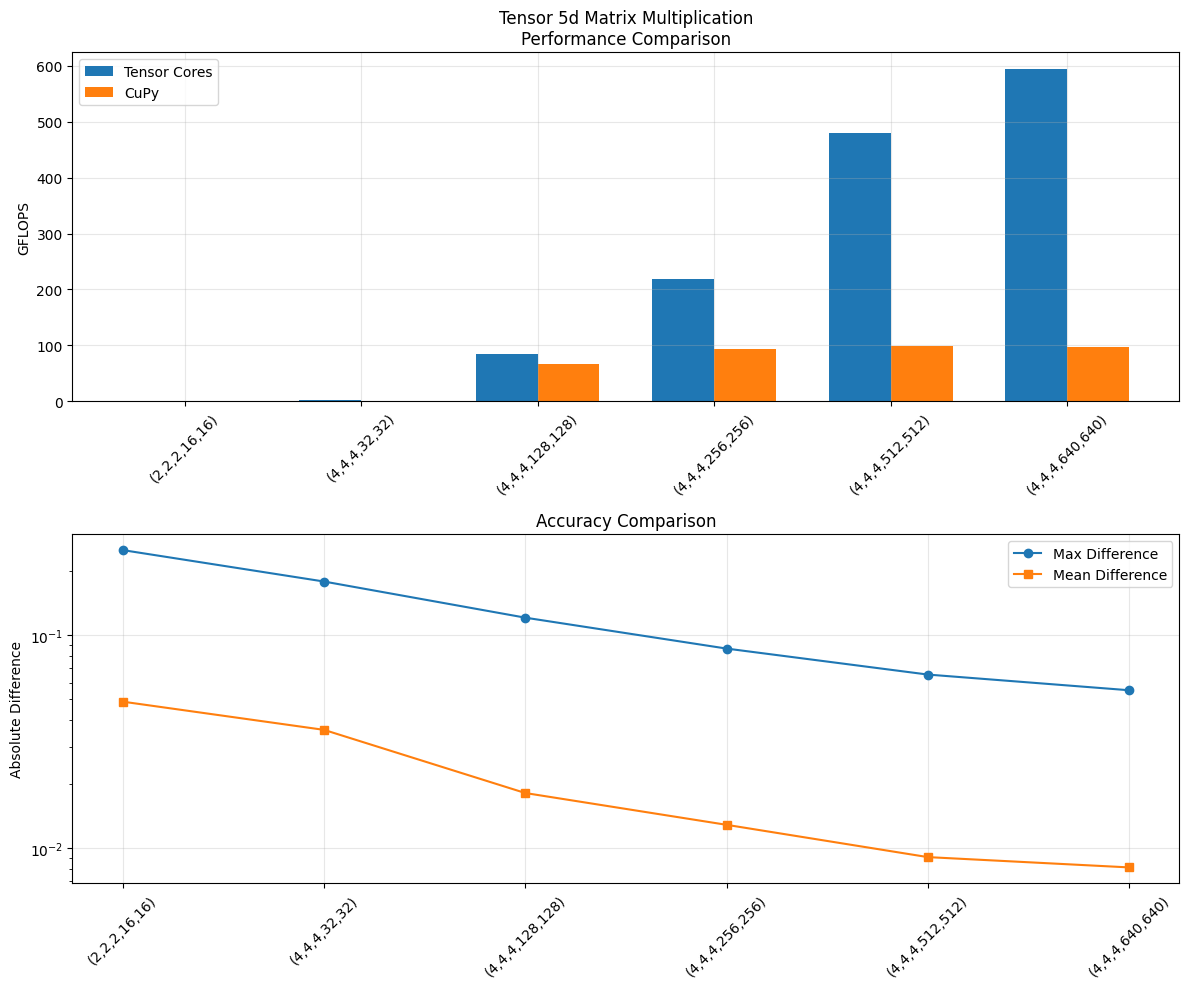


Detailed Comparison:
--------------------------------------------------------------------------------
Shape                       Tensor GFLOPS     CuPy GFLOPS     Max Diff    Mean Diff
--------------------------------------------------------------------------------
(2,2,2,16,16)                        0.22            0.13     2.51e-01     4.88e-02
(4,4,4,32,32)                        2.16            1.07     1.79e-01     3.59e-02
(4,4,4,128,128)                     83.53           66.43     1.21e-01     1.82e-02
(4,4,4,256,256)                    218.05           93.36     8.66e-02     1.29e-02
(4,4,4,512,512)                    480.18           99.63     6.54e-02     9.08e-03
(4,4,4,640,640)                    594.84           97.00     5.52e-02     8.12e-03

Sample Output Comparison (first 5 values):
--------------------------------------------------------------------------------

Shape: (2, 2, 2, 16, 16)
Tensor: [0.19986062 0.20334883 0.22292003 0.21396522 0.1443634 ]
CuPy:   [0.1

In [12]:
import numpy as np
import cupy as cp
import time
from tensor_matrix_ops import TensorMatrixOps
import matplotlib.pyplot as plt

def tensor_vs_cupy_comparison(shapes=None, num_runs=5, seed=42):  # Add a seed argument
    """Compare tensor core vs cupy implementation for performance and accuracy."""

    # Set the random seeds for reproducibility
    np.random.seed(seed)  # Set NumPy seed
    cp.random.seed(seed)  # Set CuPy seed

    # ... (rest of the function remains the same) ...
    # Default test shapes if none provided
    if shapes is None:
        # (batch, channels, depth, height, width)
        shapes = [
            (2, 2, 2, 16, 16),    
            (4, 4, 4, 32, 32),    
            (4, 4, 4, 128, 128),  
            (4, 4, 4, 256, 256), 
            (4, 4, 4, 512, 512),
            (4, 4, 4, 640, 640)
        ]

    results = []

    for shape in shapes:
        print(f"\nTesting shape: {shape}")
        batch_size, channels, depth, height, width = shape
        new_width = width  # For these tests.  Could be different.

        # Calculate theoretical operations
        flops = 2 * batch_size * channels * depth * height * width * new_width
        print(f"Operations: {flops:,}")

        try:
            # Initialize implementations
            tensor_ops = TensorMatrixOps()

            # Create test data (Fortran order)
            a = cp.random.random(shape, dtype=cp.float64)
            a = cp.asfortranarray(a)
            b = cp.random.random((batch_size, channels, depth, width, new_width), dtype=cp.float64)
            b = cp.asfortranarray(b)


            # Scale inputs to prevent overflow
            scale = cp.sqrt(width)
            a /= (scale * 1.1)
            b /= (scale * 1.1)

            # Time tensor core implementation
            tensor_times = []
            print("Running tensor core tests...")
            for i in range(num_runs):
                start = time.perf_counter()
                c_tensor = tensor_ops.tensor_5d_matmul(a, b)  # Pass a and b directly
                cp.cuda.Stream.null.synchronize()
                elapsed = time.perf_counter() - start
                tensor_times.append(elapsed)
                tensor_gflops = flops / (elapsed * 1e9)
                print(f"Tensor Run {i+1}: {elapsed*1000:.2f}ms ({tensor_gflops:.2f} GFLOPS)")


            # Time cupy implementation
            print("Running CuPy tests...")
            cupy_times = []
            # Reshape for cupy with correct dimensions
            a_2d = a.reshape(batch_size * channels * depth, height, width)
            b_2d = b.reshape(batch_size * channels * depth, width, new_width)

            print(f"\nMatrix multiplication dimensions:")
            print(f"a_2d shape: {a_2d.shape}")
            print(f"b_2d shape: {b_2d.shape}")

            for i in range(num_runs):
                start = time.perf_counter()
                c_cupy_reshaped = cp.zeros((batch_size * channels * depth, height, new_width), order='F', dtype=cp.float64)

                for j in range(batch_size * channels * depth):
                  c_cupy_reshaped[j,:,:] = cp.matmul(a_2d[j,:,:], b_2d[j,:,:])

                cp.cuda.Stream.null.synchronize()
                elapsed = time.perf_counter() - start
                cupy_times.append(elapsed)
                cupy_gflops = flops / (elapsed * 1e9)
                print(f"CuPy Run {i+1}: {elapsed*1000:.2f}ms ({cupy_gflops:.2f} GFLOPS)")
            c_cupy = c_cupy_reshaped.reshape(batch_size, channels, depth, height, new_width)
            print(f"c_cupy shape: {c_cupy.shape}")


            # Compare results
            print("Computing differences...")
            max_diff = cp.max(cp.abs(c_tensor - c_cupy))
            mean_diff = cp.mean(cp.abs(c_tensor - c_cupy))
            std_diff = cp.std(cp.abs(c_tensor - c_cupy))

            # Store results
            results.append({
                'shape': shape,
                'flops': flops,
                'tensor_times': tensor_times,
                'cupy_times': cupy_times,
                'tensor_gflops': flops / (min(tensor_times) * 1e9),
                'cupy_gflops': flops / (min(cupy_times) * 1e9),
                'max_diff': float(max_diff),
                'mean_diff': float(mean_diff),
                'std_diff': float(std_diff),
                'sample_tensor': cp.asnumpy(c_tensor[0,0,0,0,:5]),
                'sample_cupy': cp.asnumpy(c_cupy[0,0,0,0,:5])
            })

            # Clean up GPU memory
            del a, b, c_tensor, c_cupy, a_2d, b_2d, c_cupy_reshaped
            cp.get_default_memory_pool().free_all_blocks()

        except Exception as e:
            print(f"Error testing shape {shape}: {e}")
            import traceback
            traceback.print_exc()

    # Plot results if we have any
    if results:
        plot_comparison(results)

        # Print detailed comparison
        print("\nDetailed Comparison:")
        print("-" * 80)
        print(f"{'Shape':25} {'Tensor GFLOPS':>15} {'CuPy GFLOPS':>15} {'Max Diff':>12} {'Mean Diff':>12}")
        print("-" * 80)

        for r in results:
            shape_str = f"({','.join(map(str, r['shape']))})"
            print(f"{shape_str:25} {r['tensor_gflops']:15.2f} {r['cupy_gflops']:15.2f} "
                  f"{r['max_diff']:12.2e} {r['mean_diff']:12.2e}")

        print("\nSample Output Comparison (first 5 values):")
        print("-" * 80)
        for r in results:
            print(f"\nShape: {r['shape']}")
            print(f"Tensor: {r['sample_tensor']}")
            print(f"CuPy:   {r['sample_cupy']}")

    return results

def plot_comparison(results):
    """Create comparison plots for performance and accuracy."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Performance comparison
    shapes = [f"({','.join(map(str, r['shape']))})" for r in results]
    tensor_gflops = [r['tensor_gflops'] for r in results]
    cupy_gflops = [r['cupy_gflops'] for r in results]

    x = np.arange(len(shapes))
    width = 0.35
    operation_name="Tensor 5d Matrix Multiplication"

    ax1.bar(x - width/2, tensor_gflops, width, label='Tensor Cores')
    ax1.bar(x + width/2, cupy_gflops, width, label='CuPy')
    ax1.set_ylabel('GFLOPS')
    ax1.set_title(f'{operation_name}\nPerformance Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(shapes, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy comparison
    max_diffs = [r['max_diff'] for r in results]
    mean_diffs = [r['mean_diff'] for r in results]

    ax2.plot(x, max_diffs, 'o-', label='Max Difference')
    ax2.plot(x, mean_diffs, 's-', label='Mean Difference')
    ax2.set_ylabel('Absolute Difference')
    ax2.set_title('Accuracy Comparison')
    ax2.set_xticks(x)
    ax2.set_xticklabels(shapes, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("Starting comparison...")
    try:
        results = tensor_vs_cupy_comparison() # Use default seed, or specify one
        # results = tensor_vs_cupy_comparison(seed=123)  # Example with a different seed
    except Exception as e:
        print(f"Test failed: {e}")

# it is CuPy that is running out of memory, not the tensor cores!